In [3]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import sys

In [4]:
import os
import sys
sys.path.append(sys.path[0]+'/../lib')

In [5]:
from opts import opts
from datasets.dataset_factory import get_dataset
from datasets.dataset.coco import COCO
from datasets.sample.ctdet import CTDetDataset
from trains.ctdet import CtdetTrainer
from trains.train_factory import train_factory

In [6]:
Dataset = get_dataset('coco', 'ctdet')

In [7]:
sys.path.append(sys.path[0]+'/../project_tools')
from fcn_opts import fcn_opts
opt = fcn_opts(Dataset)

## Loading Dataset

In [8]:
dataset = Dataset(opt,'train')
valset = Dataset(opt, 'val')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=20.34s)
creating index...
index created!
Loaded train 118287 samples
==> initializing coco 2017 val data.
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Loaded val 5000 samples


In [9]:
opt.batch_size

8

### Modifying dataset

In [10]:
all_Ids=dataset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/train2017/'

118287


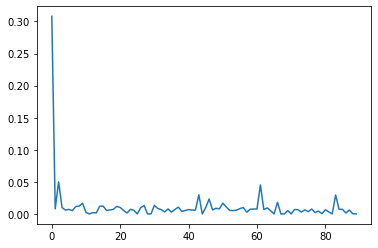

In [11]:
N=8192
import random
np.random.seed(0)
numsets=1
for iter in range(numsets):
    imgIds_perm=np.random.permutation(len(all_Ids))
    tmp=imgIds_perm[0:N].astype(int)
    tmp2=[all_Ids[t] for t in tmp]
    dataset.images=tmp2
    dataset.num_samples=len(dataset.images)
    sub_inst_cat=np.zeros(90)
    for j in range(N):
        sub_cat_lab=[]
        img = dataset.coco.loadImgs(dataset.images[j])[0]
        f_name=img_dir
        f_name+=img['file_name']
        annIds = dataset.coco.getAnnIds(imgIds=img['id'])
        anns = dataset.coco.loadAnns(annIds)
        sub_cat_lab=[k['category_id'] for k in anns]
        for jj in range(90):
            t=np.where(np.asarray(sub_cat_lab)==jj)
            sub_inst_cat[jj-1]+=t[0].shape[0]
    prob_sub=(sub_inst_cat+1)/np.sum(sub_inst_cat+1)    
    plt.plot(sub_inst_cat/(np.sum(sub_inst_cat)))
np.random.seed(2)

In [12]:
opt.num_iters = dataset.num_samples/opt.batch_size

In [13]:
all_Ids=valset.coco.getImgIds()
print(len(all_Ids))
import skimage.io as io
img_dir='~/MoDL_CenterNet/data/coco/val2017/'

5000


In [14]:
N=512
np.random.seed(0)
imgIds_perm=np.random.permutation(len(all_Ids))
tmp=imgIds_perm[0:N].astype(int)
tmp2=[all_Ids[t] for t in tmp]
valset.images=tmp2
valset.num_samples=len(valset.images)
np.random.seed(2)

In [15]:
len(valset)

512

## Experiment

In [16]:
sys.path.append(sys.path[0]+"/../project_tools")
import nntools as nt
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from models.model import create_model, load_model, save_model
from trains.ctdet import CtdetTrainer

In [17]:
class Centernet_model(nt.NeuralNetwork,CtdetTrainer):
    def __init__(self,opt,model,optimizer=None,FineTune=True):
        nt.NeuralNetwork.__init__(self)
        CtdetTrainer.__init__(self,opt,model,optimizer=None)
        if FineTune:
            for name,param in model.named_parameters():
                if name[0:2]=='hm' or name[0:2]=='re' or name[0:2]=='wh':
                    #print(name, 'size=', param.data.shape, 'std=', torch.std(param.data), 'mean=', torch.mean(param.data), torch.sum(param.data**2))
                    param.data = 0.1*torch.randn(param.size()) # Random initialization
                else:
                    param.requires_grad=False
                    #print(name, 'size=', param.data.shape, 'std=', torch.std(param.data), 'mean=', torch.mean(param.data), torch.sum(param.data**2))
            #print(name,param.requires_grad)
        self.model = model
        self.opt=opt
    def forward(self,x):
        return self.model(x)
    def criterion(self, y, d):
        return self.loss(y,d)

In [18]:
model = create_model(opt.arch, opt.heads, opt.head_conv)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 15.9MB/s]


=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution


In [19]:
for name,param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [20]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
model =load_model(model,sys.path[0]+'/../../models/ctdet_coco_resdcn18.pth');
net = Centernet_model(opt,model);
net = net.to(opt.device)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/src/local_notebooks/../../models/ctdet_coco_resdcn18.pth, epoch 140


In [21]:
optimizer = torch.optim.Adam(net.parameters(), opt.lr)

In [22]:
stats_manager1 = nt.StatsManager()
exp1 = nt.Experiment(net,dataset,valset,optimizer,stats_manager1,
output_dir="BaseExperiment_train8192", batch_size=opt.batch_size,perform_validation_during_training=False)

In [23]:
exp1.run2(num_epochs=200)

Start/Continue training from epoch 141


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 142 (Time: 388.93s)
Epoch 143 (Time: 344.51s)
Epoch 144 (Time: 344.38s)
Epoch 145 (Time: 353.98s)
Epoch 146 (Time: 359.97s)
Epoch 147 (Time: 401.87s)
Epoch 148 (Time: 349.48s)
Epoch 149 (Time: 346.36s)
Epoch 150 (Time: 363.79s)
Epoch 151 (Time: 350.42s)
Epoch 152 (Time: 349.88s)
Epoch 153 (Time: 351.81s)
Epoch 154 (Time: 346.17s)
Epoch 155 (Time: 352.64s)
Epoch 156 (Time: 356.17s)
Epoch 157 (Time: 362.72s)
Epoch 158 (Time: 361.95s)
Epoch 159 (Time: 384.29s)
Epoch 160 (Time: 388.03s)
Epoch 161 (Time: 371.20s)
Epoch 162 (Time: 345.68s)
Epoch 163 (Time: 346.70s)
Epoch 164 (Time: 341.51s)
Epoch 165 (Time: 339.57s)
Epoch 166 (Time: 354.80s)
Epoch 167 (Time: 352.00s)
Epoch 168 (Time: 344.67s)
Epoch 169 (Time: 343.09s)
Epoch 170 (Time: 356.79s)
Epoch 171 (Time: 345.37s)
Epoch 172 (Time: 342.64s)
Epoch 173 (Time: 354.02s)
Epoch 174 (Time: 341.39s)
Epoch 175 (Time: 345.70s)
Epoch 176 (Time: 341.86s)
Epoch 177 (Time: 361.07s)
Epoch 178 (Time: 350.00s)
Epoch 179 (Time: 351.66s)
Epoch 180 (T

In [29]:
print(np.min(exp1.history))
plt.show()

1.9066022286424413


In [28]:
exp1.evaluate2()

2.1001939819861946

## Detector

In [29]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [23]:
opt.load_model = '/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth'
opt.K = 100
detector = CtdetDetector(opt)
detector.model = exp1.net.model
detector.model.eval();

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [24]:
results = {}
for tst_id in range(1):
    img_id = valset.images[tst_id]
    img_id = 260261
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

In [25]:
ret['results']

{1: array([[ 1.69299133e+02,  1.64716003e+02,  3.50894897e+02,
          6.30384949e+02,  8.95834982e-01],
        [-2.75534821e+00,  1.68371429e+02,  7.26760406e+01,
          2.96406860e+02,  1.03421174e-01],
        [ 1.83509949e+02,  3.87195770e+02,  2.26342896e+02,
          4.21326111e+02,  1.02370732e-01]], dtype=float32),
 2: array([], shape=(0, 5), dtype=float32),
 3: array([[3.6281818e+02, 2.2909955e+02, 4.2693005e+02, 2.7544858e+02,
         5.5952334e-01],
        [3.4656219e+02, 2.2290155e+02, 3.7482767e+02, 2.5210715e+02,
         1.5521677e-01],
        [1.2240818e+01, 1.9048785e+02, 2.4871579e+02, 3.2384338e+02,
         1.3531990e-01],
        [3.1516382e+02, 2.2292352e+02, 3.3615936e+02, 2.5190802e+02,
         1.0829067e-01]], dtype=float32),
 4: array([], shape=(0, 5), dtype=float32),
 5: array([], shape=(0, 5), dtype=float32),
 6: array([[2.9252423e+02, 1.7171614e+02, 3.7872260e+02, 2.5438933e+02,
         1.0367130e-01]], dtype=float32),
 7: array([], shape=(0, 5)

{'license': 3, 'file_name': '000000260261.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000260261.jpg', 'height': 640, 'width': 426, 'date_captured': '2013-11-17 21:38:07', 'flickr_url': 'http://farm8.staticflickr.com/7163/6565710667_eecd09013c_z.jpg', 'id': 260261}


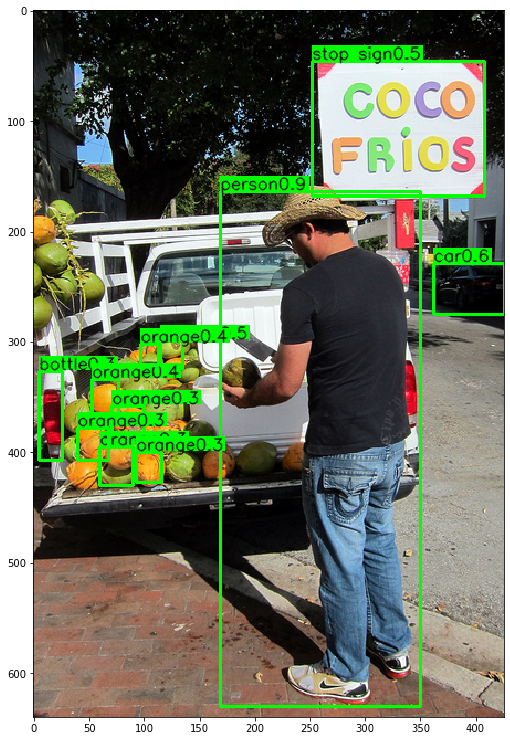

In [26]:
coco_class_name = [
     'person', 'bicycle', 'car', 'motorcycle', 'airplane',
     'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
     'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
     'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
     'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
     'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
     'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
     'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
     'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
     'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
     'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

#for kk in valset[0]:
#    print(kk)

import cv2
im_id = valset[tst_id]['meta']['img_id']
im_id = 260261
img = valset.coco.loadImgs(im_id)[0]
print(img)
img_dir='~/MoDL_CenterNet/data/coco/val2017/'
f_name=img_dir
f_name+=img['file_name']
import skimage.io as io
I = io.imread(f_name)
show_txt = True
for c_id in range(80):
    for j in range(ret['results'][c_id+1].shape[0]):
        if ret['results'][c_id+1][j][4]>=opt.vis_thresh:
            bbox = ret['results'][c_id+1][j]
            cv2.rectangle(I, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 2)
            if show_txt:
                txt = '{}{:.1f}'.format(coco_class_name[c_id], bbox[4]) # text+confidence
                font = cv2.FONT_HERSHEY_SIMPLEX
                cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
                cv2.rectangle(I, (bbox[0], int(bbox[1] - cat_size[1] - 2)),(int(bbox[0] + cat_size[0]), int(bbox[1] - 2)), (0,255,0), -1)
                cv2.putText(I, txt, (bbox[0], int(bbox[1] - 2)), font, 0.5, (0, 0, 0),thickness=1, lineType=cv2.LINE_AA)


fig, axes = plt.subplots(figsize=(13,13))
axes.imshow(I)
#im=np.moveaxis(im,[0,1,2],[2,0,1])
#im = im.reshape(512,512,3)
#cv2
#print(im.shape)

## Evaluation 

In [32]:
sys.path.append(sys.path[0]+'/../lib/models/networks/DCNv2')
from detectors.ctdet import CtdetDetector

In [33]:
opt.load_model = '/datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth'
opt.K = 100
detector = CtdetDetector(opt)
detector.model = exp1.net.model
detector.model.eval();

Creating model...
=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
loaded /datasets/home/home-01/40/940/rpote/MoDL_CenterNet/models/ctdet_coco_resdcn18.pth, epoch 140


In [34]:
results = {}
for tst_id in range(len(valset)):
    if np.mod(tst_id, 100)==0:
        print(tst_id)
    img_id = valset.images[tst_id]
    img_info = valset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(valset.img_dir, img_info['file_name'])
    ret = detector.run(img_path)
    results[img_id] = ret['results']

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [35]:
opt.save_dir = sys.path[0]+'/Base_case_v2-train8192_Results'
valset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=5.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=72.40s).
Accumulating evaluation results...
DONE (t=17.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=